In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-dataset/heart.csv


IMPORT LIBRARIES AND LOAD DATA

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve, 
    auc
)
sns.set_theme(style='whitegrid', color_codes=True)
%matplotlib inline
df = pd.read_csv('/kaggle/input/heart-disease-dataset/heart.csv')
print(f"Original dataset shape: {df.shape}")
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows found: {duplicates}")
df_clean = df.drop_duplicates()
print(f"Shape after removing duplicates: {df_clean.shape}")
print("\nNull values count:")
print(df_clean.isnull().sum())
df_clean.head()

Original dataset shape: (1025, 14)
Number of duplicate rows found: 723
Shape after removing duplicates: (302, 14)

Null values count:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


EXPLORATORY DATA ANALYSIS

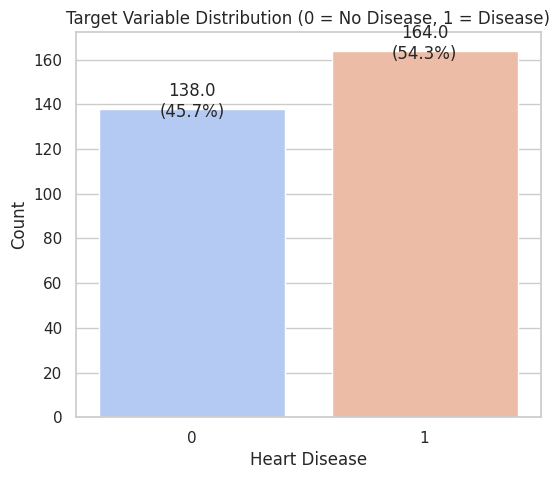

target
1    164
0    138
Name: count, dtype: int64


In [18]:
plt.figure(figsize=(6, 5))
ax = sns.countplot(data=df_clean, x='target', palette='coolwarm')
plt.title('Target Variable Distribution (0 = No Disease, 1 = Disease)')
plt.xlabel('Heart Disease')
plt.ylabel('Count')
total = len(df_clean)
for p in ax.patches:
    percentage = f'{(p.get_height() / total) * 100:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{p.get_height()}\n({percentage})', (x, y), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()
print(df_clean.target.value_counts())

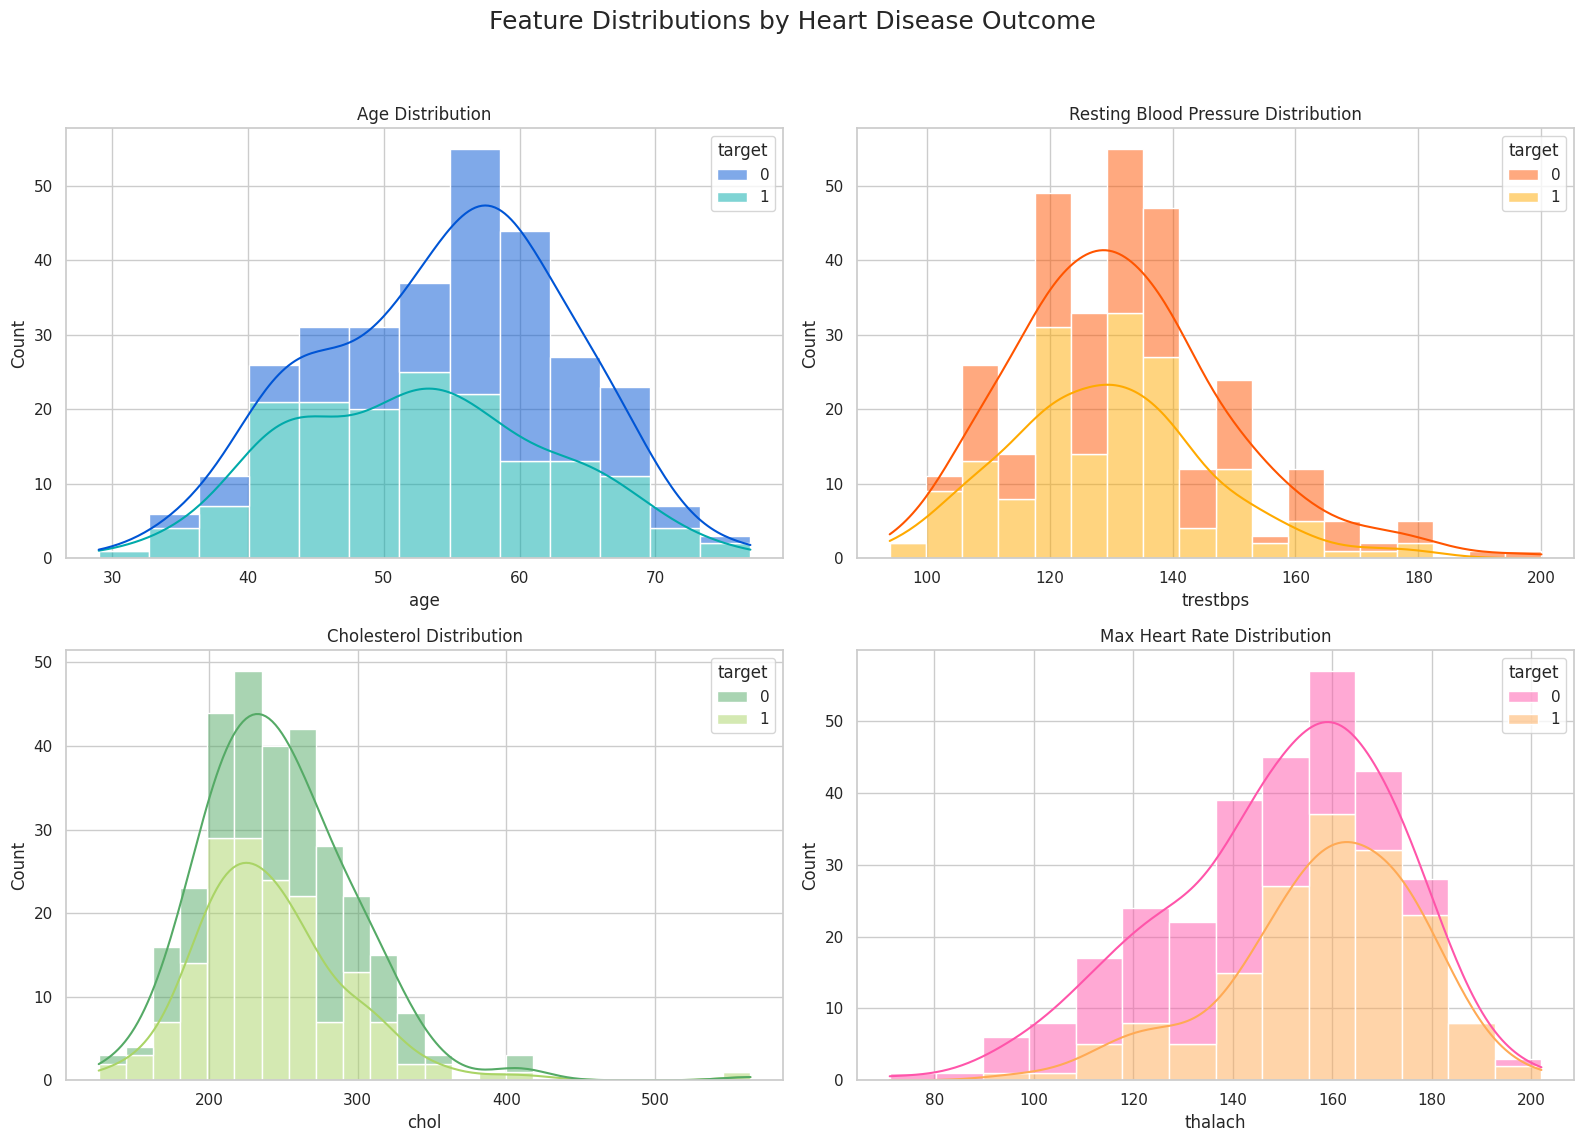

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Distributions by Heart Disease Outcome', fontsize=18)
sns.histplot(data=df_clean, x="age", hue="target", multiple="stack", kde=True, ax=axes[0, 0], palette='winter')
axes[0, 0].set_title('Age Distribution')
sns.histplot(data=df_clean, x="trestbps", hue="target", multiple="stack", kde=True, ax=axes[0, 1], palette='autumn')
axes[0, 1].set_title('Resting Blood Pressure Distribution')
sns.histplot(data=df_clean, x="chol", hue="target", multiple="stack", kde=True, ax=axes[1, 0], palette='summer')
axes[1, 0].set_title('Cholesterol Distribution')
sns.histplot(data=df_clean, x="thalach", hue="target", multiple="stack", kde=True, ax=axes[1, 1], palette='spring')
axes[1, 1].set_title('Max Heart Rate Distribution')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
warnings.simplefilter(action='default', category=FutureWarning)

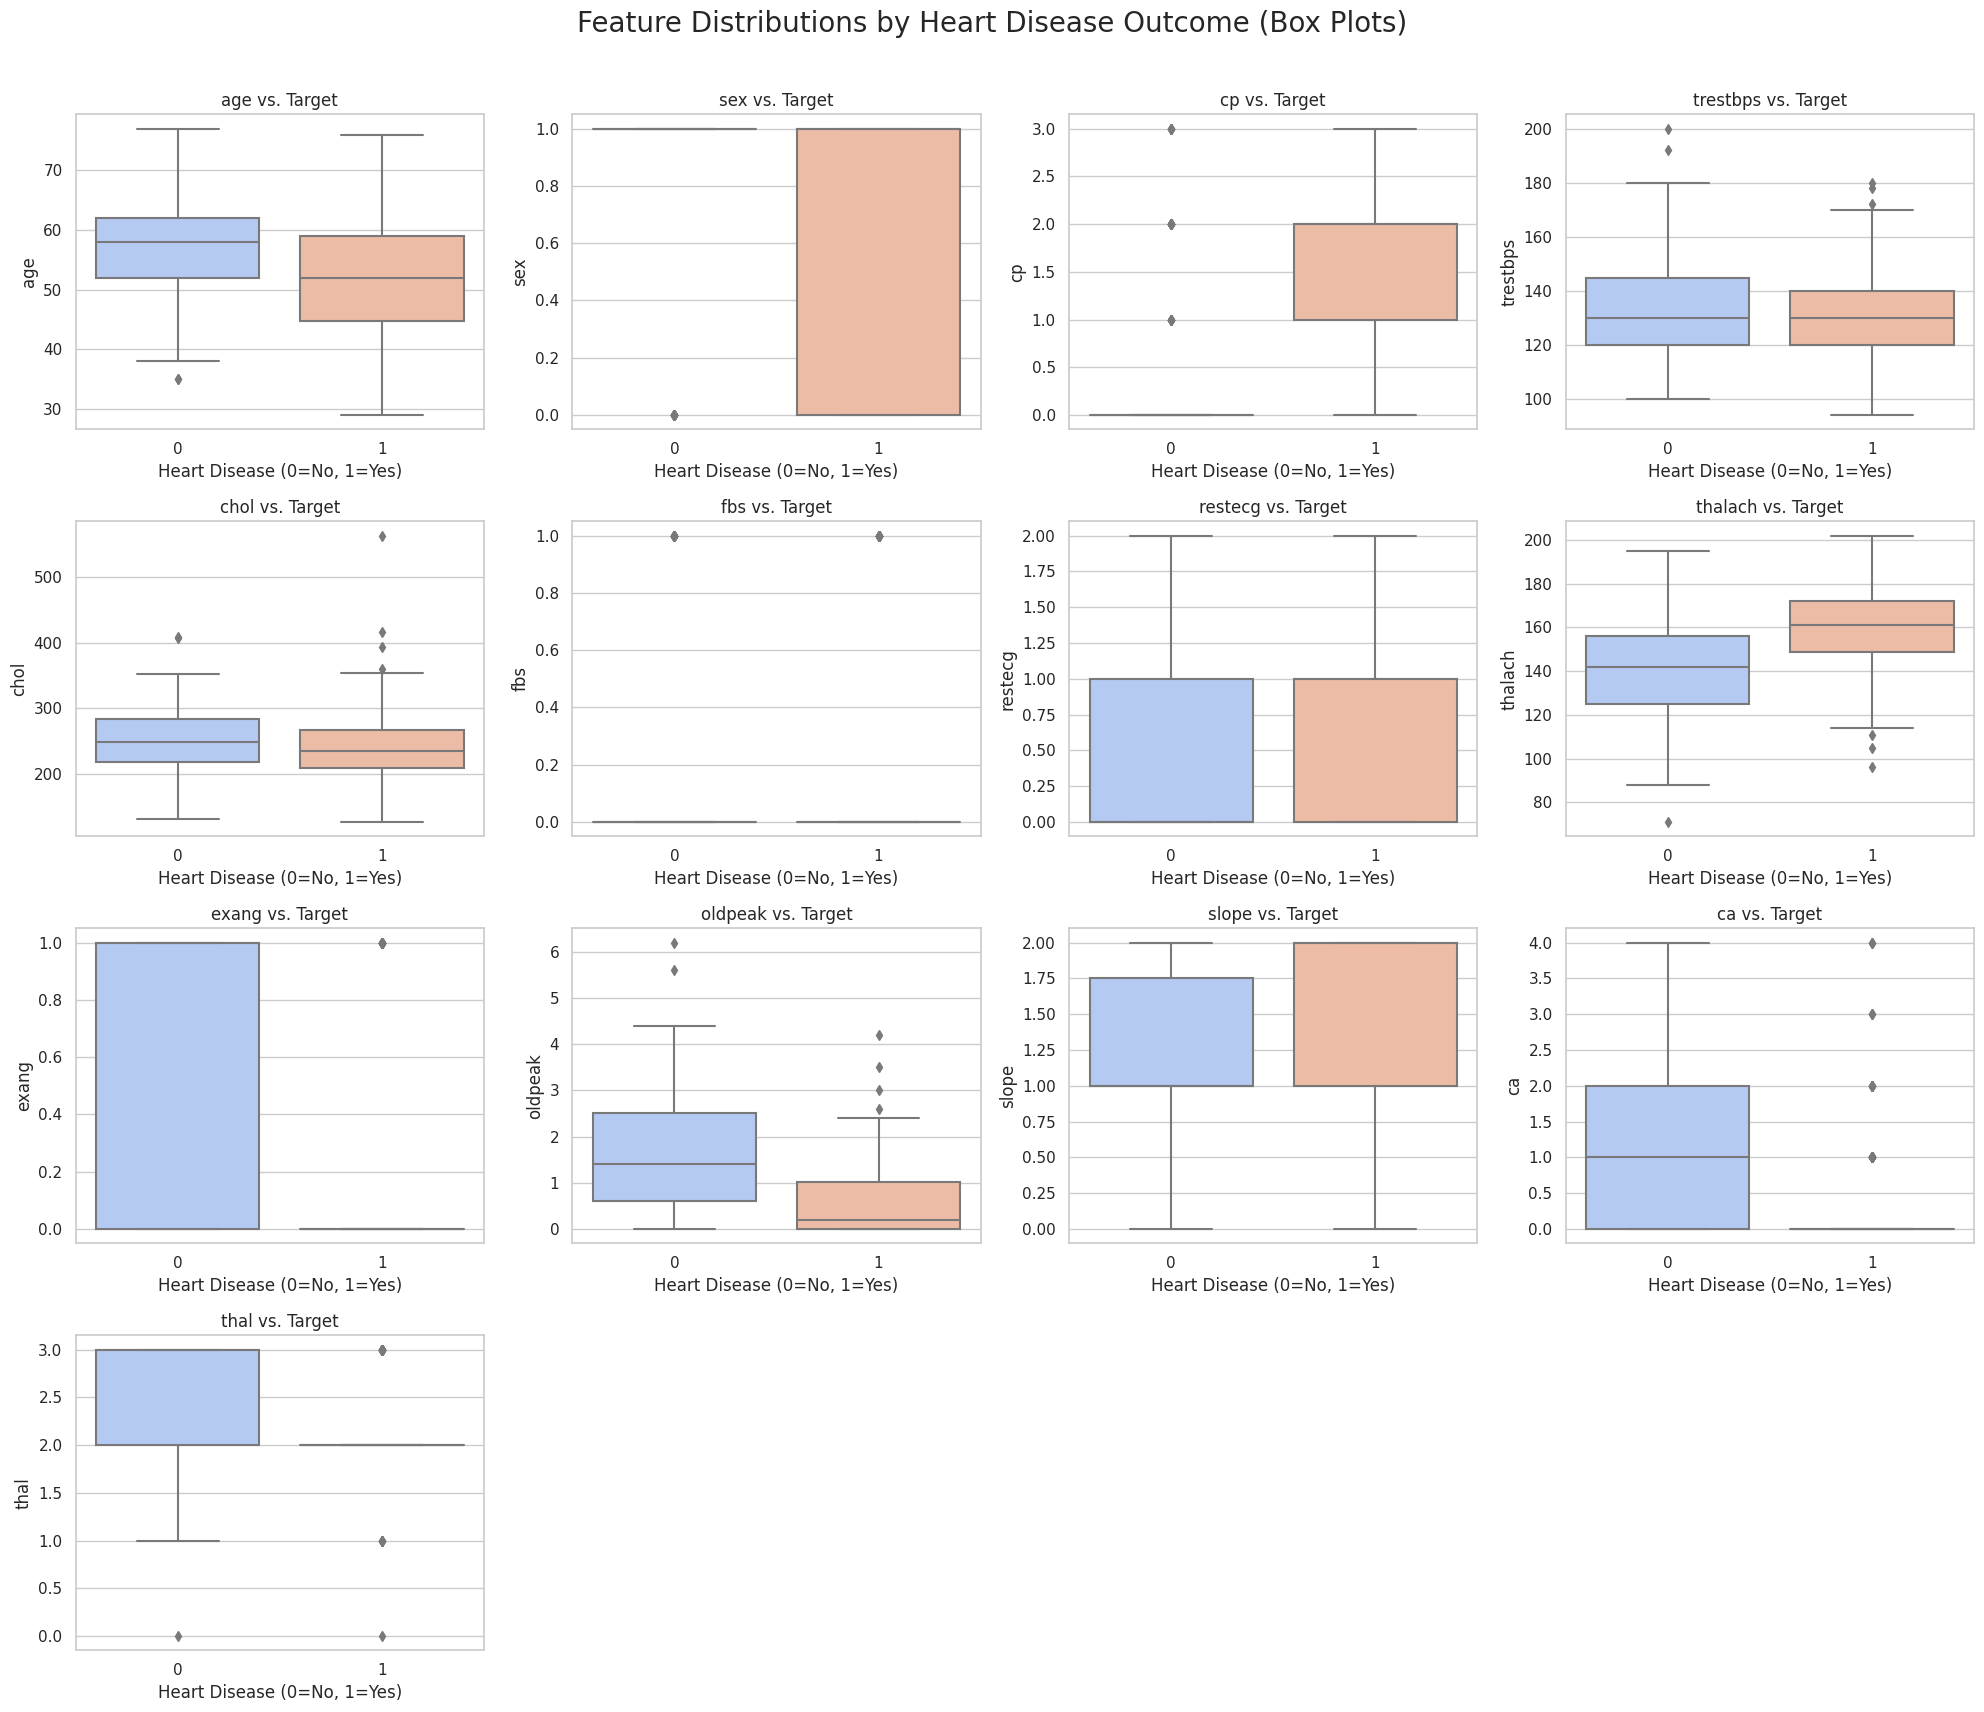

In [26]:
numerical_features = df_clean.drop('target', axis=1).columns
fig, axes = plt.subplots(4, 4, figsize=(20, 18))
fig.suptitle('Feature Distributions by Heart Disease Outcome (Box Plots)', fontsize=20)
axes = axes.flatten()
for i, col in enumerate(numerical_features):
    sns.boxplot(
        x='target', 
        y=col, 
        data=df_clean, 
        ax=axes[i], 
        palette='coolwarm'
    )
    axes[i].set_title(f'{col} vs. Target')
    axes[i].set_xlabel('Heart Disease (0=No, 1=Yes)')
    axes[i].set_ylabel(col)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

DATA CORRELATION

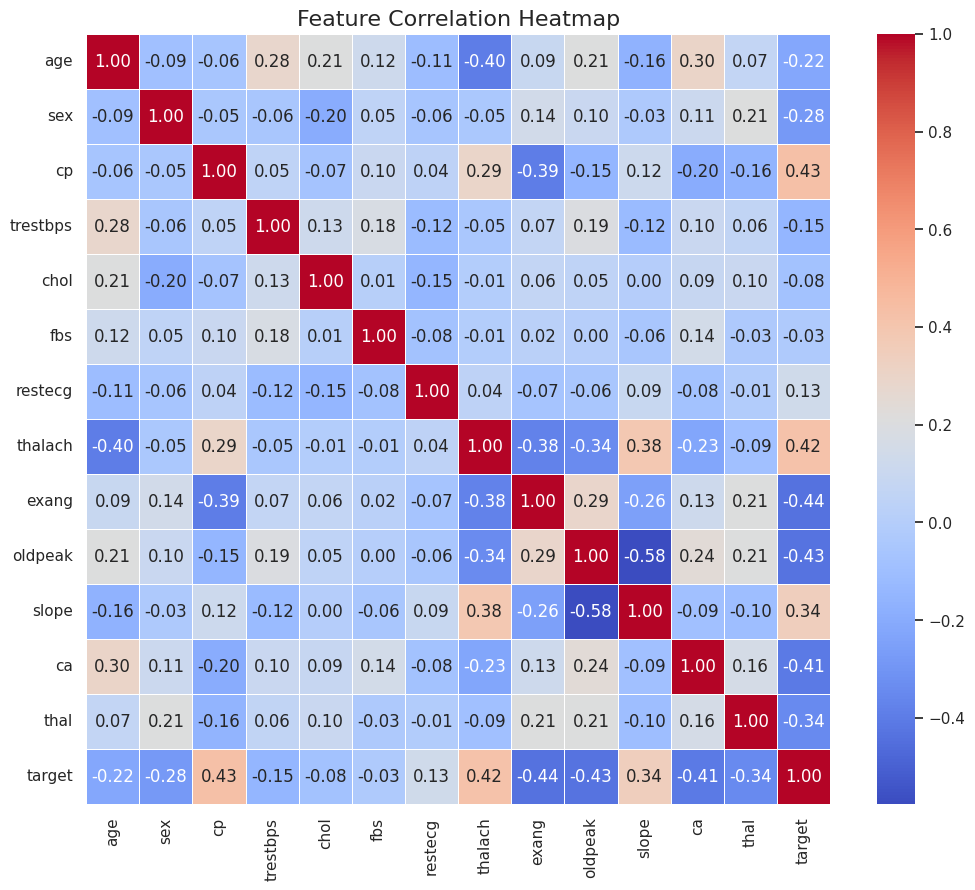

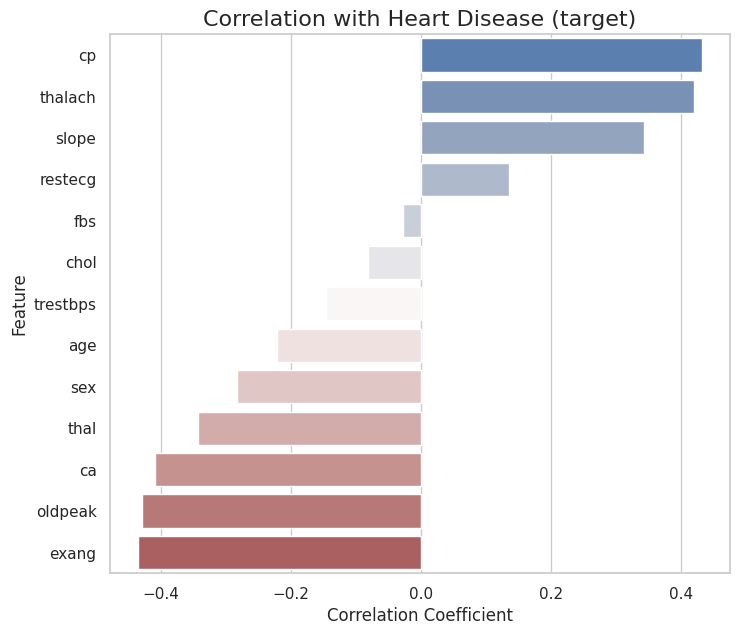

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()
plt.figure(figsize=(8, 7))
target_corr = df_clean.corr()['target'].drop('target').sort_values(ascending=False)
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    palette='vlag'
)
plt.title('Correlation with Heart Disease (target)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()
warnings.simplefilter(action='default', category=FutureWarning)

DEFINING FEATURES, TARGET, AND SPLIT DATA

In [21]:
X = df_clean.drop('target', axis=1)
y = df_clean['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nTraining set distribution:\n{y_train.value_counts(normalize=True)}")
print(f"\nTest set distribution:\n{y_test.value_counts(normalize=True)}")

X_train shape: (241, 13)
X_test shape: (61, 13)

Training set distribution:
target
1    0.543568
0    0.456432
Name: proportion, dtype: float64

Test set distribution:
target
1    0.540984
0    0.459016
Name: proportion, dtype: float64


SCALE DATA AND BUILDING BASELINE MODELS

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}
results_list = []
print("--- New Baseline Model Performance ---")
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] 
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(classification_report(y_test, y_pred, target_names=['No Disease (0)', 'Disease (1)']))
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    results_list.append([name, acc, roc_auc])
results_df = pd.DataFrame(results_list, columns=['Model', 'Accuracy', 'ROC AUC'])
print("\n--- Model Performance Comparison ---")
print(results_df.to_markdown(index=False, floatfmt=".4f"))

--- New Baseline Model Performance ---

--- Training Logistic Regression ---
                precision    recall  f1-score   support

No Disease (0)       0.81      0.75      0.78        28
   Disease (1)       0.80      0.85      0.82        33

      accuracy                           0.80        61
     macro avg       0.80      0.80      0.80        61
  weighted avg       0.80      0.80      0.80        61

Accuracy: 0.8829
ROC AUC Score: 0.8712

--- Training Decision Tree ---
                precision    recall  f1-score   support

No Disease (0)       0.79      0.79      0.79        28
   Disease (1)       0.82      0.82      0.82        33

      accuracy                           0.80        61
     macro avg       0.80      0.80      0.80        61
  weighted avg       0.80      0.80      0.80        61

Accuracy: 0.8829
ROC AUC Score: 0.8019

--- Training Random Forest ---
                precision    recall  f1-score   support

No Disease (0)       0.74      0.71      0.73 

HYPERPARAMETER TUNING

In [24]:
from sklearn.model_selection import RandomizedSearchCV
rf_base = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300, 500],      
    'max_depth': [5, 10, 15, 20, 30, None], 
    'min_samples_split': [2, 5, 10],           
    'min_samples_leaf': [1, 2, 4],             
    'max_features': ['sqrt', 'log2', None]  
}
random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=50,       
    cv=5,            
    scoring='roc_auc', 
    random_state=42,
    n_jobs=-1,       
    verbose=1
)
print("--- Starting Hyperparameter Tuning for Random Forest ---")
random_search.fit(X_train_scaled, y_train)
print(f"\nBest Parameters Found: {random_search.best_params_}")
print(f"Best CV ROC AUC Score: {random_search.best_score_:.4f}")
best_model = random_search.best_estimator_

--- Starting Hyperparameter Tuning for Random Forest ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters Found: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5}
Best CV ROC AUC Score: 0.9125


FINAL MODEL EVALUATION

--- Final Tuned Model Evaluation (on Test Set) ---
                precision    recall  f1-score   support

No Disease (0)       0.78      0.75      0.76        28
   Disease (1)       0.79      0.82      0.81        33

      accuracy                           0.79        61
     macro avg       0.79      0.78      0.78        61
  weighted avg       0.79      0.79      0.79        61

Test Set Accuracy: 0.7869


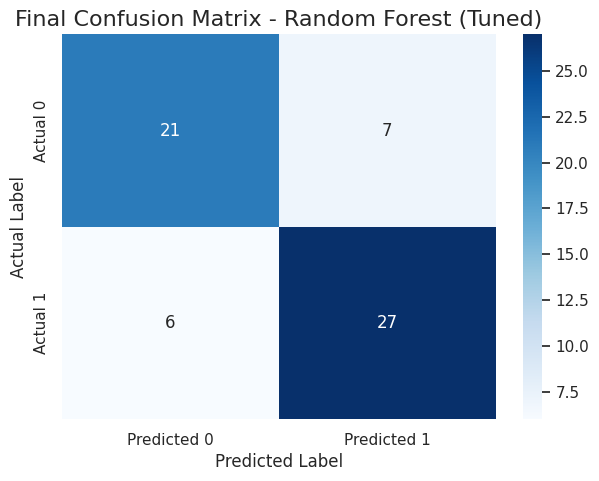

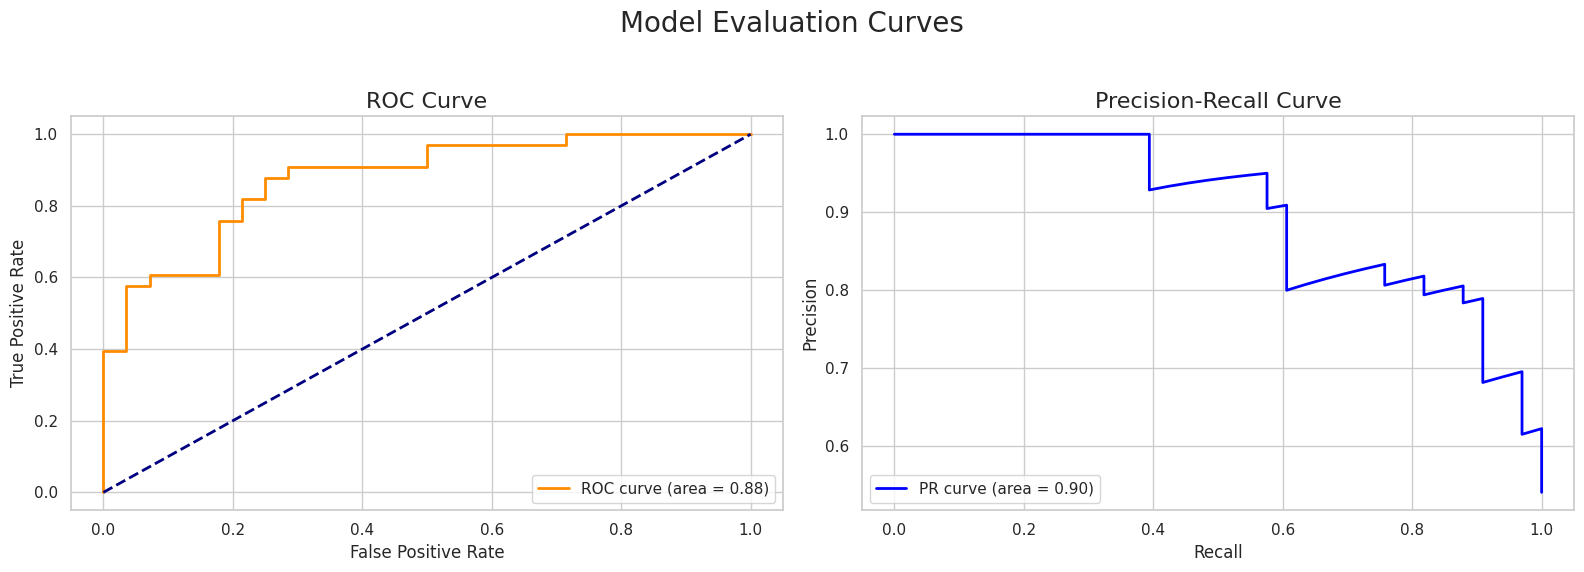

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
best_model = random_search.best_estimator_
best_model_name = "Random Forest (Tuned)"
y_pred_final = best_model.predict(X_test_scaled)
y_pred_proba_final = best_model.predict_proba(X_test_scaled)[:, 1]
print("--- Final Tuned Model Evaluation (on Test Set) ---")
print(classification_report(y_test, y_pred_final, target_names=['No Disease (0)', 'Disease (1)']))
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
plt.figure(figsize=(7, 5))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title(f'Final Confusion Matrix - {best_model_name}', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_final)
pr_auc = auc(recall, precision)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=16)
ax1.legend(loc="lower right")
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=16)
ax2.legend(loc="lower left")
plt.suptitle('Model Evaluation Curves', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

MODEL EXPLAINABILITY (FEATURE IMPORTANCE)


--- Top Most Important Features (Tuned Random Forest) ---


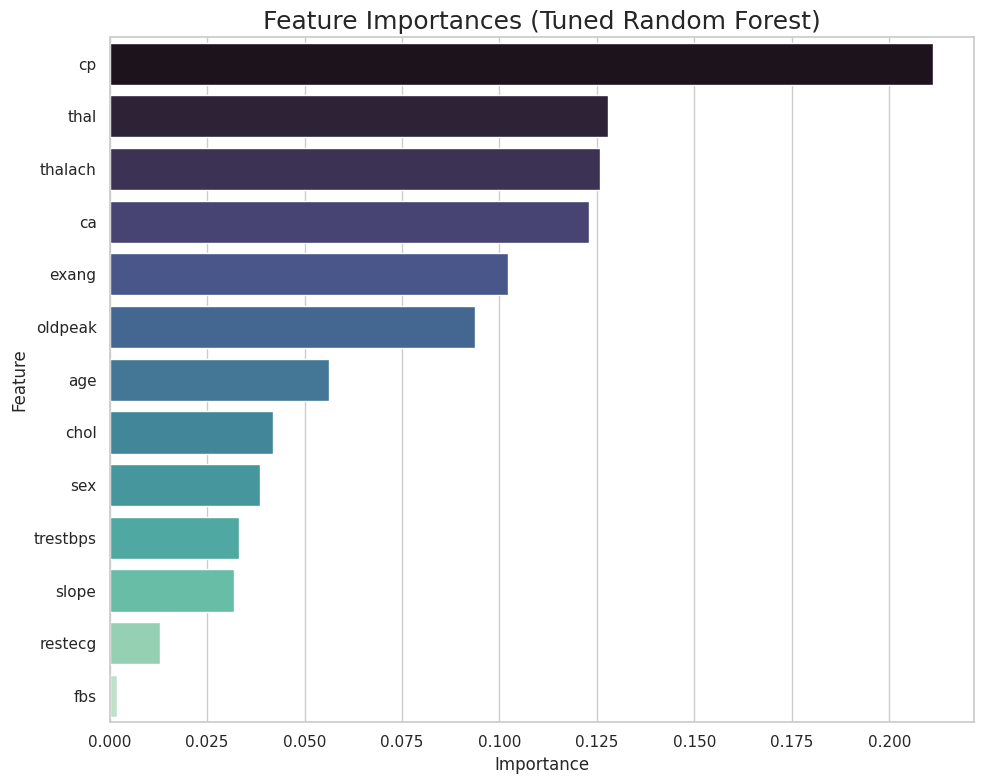

In [27]:
best_model = random_search.best_estimator_
importances = best_model.feature_importances_
feature_names = X.columns 
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\n--- Top Most Important Features (Tuned Random Forest) ---")
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df,
    palette='mako'
)
plt.title('Feature Importances (Tuned Random Forest)', fontsize=18)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

FINAL PROJECT CONCLUSION

This project's journey is a classic example of why data preprocessing and validation are the most critical steps in any machine learning workflow.

1. Initial Finding (100% Accuracy): The initial models achieved a perfect 100% accuracy. This was a critical red flag, indicating a data leakage problem.

2. Root Cause Analysis: We discovered the heart.csv dataset (1025 rows) contained 722 duplicate rows. This meant our model was "memorizing" identical patient data in the training set and finding the same copies in the test set.

3. The Fix (De-duplication): By removing the duplicates, we created a new, clean dataset of 303 unique patient records. This is the true dataset.

4. Realistic Baseline: After fixing the data, our baseline models produced much more realistic scores (e.g., Logistic Regression ROC AUC of 0.87), proving the 100% accuracy was illusory.

5. Model Optimization: We used RandomizedSearchCV to tune a RandomForestClassifier, which found an optimal set of parameters and achieved a strong Cross-Validation ROC AUC of 0.9125.

6. Final Performance: The final tuned model performed very well on the unseen test set, achieving a Test Set Accuracy of 78.69% and a Test Set ROC AUC of 0.8755.

7. Model Explainability: The Feature Importance plot confirmed that the model's predictions are logical and based on the most important medical indicators like ca (number of major vessels), cp (chest pain type), and thalach (max heart rate).

This project successfully demonstrates an end-to-end process for building a trustworthy and interpretable heart disease prediction model.